In [5]:
%matplotlib inline
from __future__ import print_function

import torch
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from cogitare.data import DataSet, AsyncDataLoader
from cogitare import utils, Model
from cogitare.plugins import EarlyStopping
from cogitare.metrics.classification import accuracy
import cogitare

import argparse

import matplotlib.pyplot as plt
import numpy as np


In [6]:

parser = argparse.ArgumentParser()
pa = parser.add_argument  # define a shortcut

pa('--batch-size', help='Size of the training batch', type=int, default=64)
pa('--cuda', help='enable cuda', action='store_true')
pa('--dropout', help='dropout rate in the input data', type=float, default=0.3)
pa('--learning-rate', help='learning rate', type=float, default=0.001)
pa('--max-epochs', help='limit the number of epochs in training', type=int, default=10)
try:
    args = parser.parse_args()
except:
    args = parser.parse_args([])
cogitare.utils.set_cuda(args.cuda)
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

usage: ipykernel_launcher.py [-h] [--batch-size BATCH_SIZE] [--cuda]
                             [--dropout DROPOUT]
                             [--learning-rate LEARNING_RATE]
                             [--max-epochs MAX_EPOCHS]
ipykernel_launcher.py: error: unrecognized arguments: -f /run/user/1000/jupyter/kernel-af4bd7f3-4d12-4e28-896d-982c819e67f8.json


In [7]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# load the CIFAR 10 data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                       download=True, transform=transform)

print(type(trainset.train_data))

Files already downloaded and verified
Files already downloaded and verified
<class 'numpy.ndarray'>


In [8]:
print(type(trainset.train_data))
print(type(trainset.train_labels))

def batch2variable(batch):
    data, label = batch
    data = utils.to_tensor(data)
    
    # B x W x H x C to B x C x W x W
    data = data.transpose(1, 2).transpose(1, 3)
    
    return utils.to_variable(data, dtype=torch.FloatTensor), utils.to_variable(label)

# convert the trainset.train_labels to LongTensor, instead of python list

data_train = DataSet([trainset.train_data, torch.LongTensor(trainset.train_labels)],
                     batch_size=args.batch_size,
                     drop_last=True)

data_train = AsyncDataLoader(data_train, buffer_size=args.batch_size * 8,
                             on_batch_loaded=batch2variable)

data_test = DataSet([testset.test_data, torch.LongTensor(testset.test_labels)],
                    batch_size=args.batch_size,
                    drop_last=True)
data_test = AsyncDataLoader(data_test, buffer_size=args.batch_size * 8,
                            on_batch_loaded=batch2variable)

# fill the data buffer
data_train.cache()
data_test.cache()

print(next(data_train))

<class 'numpy.ndarray'>
<class 'list'>
(tensor([[[[ 134.,  135.,  130.,  ...,  155.,  154.,  155.],
          [ 140.,  138.,  133.,  ...,  154.,  153.,  152.],
          [ 139.,  137.,  128.,  ...,  151.,  151.,  149.],
          ...,
          [ 120.,  124.,  131.,  ...,  124.,  124.,  125.],
          [ 127.,  131.,  129.,  ...,  130.,  132.,  130.],
          [ 135.,  135.,  128.,  ...,  117.,  124.,  127.]],

         [[ 156.,  158.,  149.,  ...,  176.,  175.,  176.],
          [ 162.,  160.,  152.,  ...,  175.,  174.,  174.],
          [ 161.,  159.,  148.,  ...,  173.,  173.,  171.],
          ...,
          [ 157.,  161.,  170.,  ...,  164.,  162.,  161.],
          [ 162.,  167.,  166.,  ...,  171.,  171.,  167.],
          [ 170.,  170.,  163.,  ...,  158.,  163.,  165.]],

         [[  82.,   84.,   84.,  ...,  108.,  107.,  108.],
          [  85.,   84.,   86.,  ...,  106.,  105.,  104.],
          [  88.,   87.,   83.,  ...,  101.,  102.,   99.],
          ...,
          [

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 3, 32, 32])
      deer       cat      bird       car

       cat      ship      deer      frog

       cat      ship     truck     truck

     truck     plane       car       cat



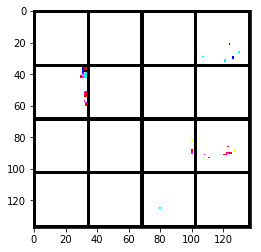

In [9]:
def imshow(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def showlabels(labels, qtd):
    for j in range(1, qtd + 1):
        print('%10s' % CLASSES[int(labels[j - 1])], end='')

        if j % 4 == 0:
            print('\n')

images, labels = next(data_train)
print(images.shape)

imshow(torchvision.utils.make_grid(images.data[:16], nrow=4))
showlabels(labels, 16)

In [10]:
class CNN(Model):
    
    def __init__(self):
        super(CNN, self).__init__()
            
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, batch):
        x, _ = batch             
        x = F.dropout(x, args.dropout)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return F.log_softmax(x, dim=1)
    
    def loss(self, output, batch):
        _, expected = batch

        return F.nll_loss(output, expected)

In [11]:
cnn = CNN()

optimizer = optim.Adam(cnn.parameters(), lr=args.learning_rate)

In [12]:
cnn.register_default_plugins()

early = EarlyStopping(max_tries=5, path='/tmp/model.pt')
cnn.register_plugin(early, 'on_end_epoch')

2018-07-25 06:49:49 qunta-B85M-D3H cogitare.core.model[10198] INFO Model: 

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

2018-07-25 06:49:49 qunta-B85M-D3H cogitare.core.model[10198] INFO Training data: 

DataSet with:
    containers: [
        TensorHolder with 781x64 samples
	TensorHolder with 781x64 samples
    ],
    batch size: 64


2018-07-25 06:49:49 qunta-B85M-D3H cogitare.core.model[10198] INFO Number of trainable parameters: 62,006
2018-07-25 06:49:49 qunta-B85M-D3H cogitare.core.model[10198] INFO Number of non-trainable parameters: 0
2018-07-25 06:49:49 qunta-B85M-D3H cogitare.core.model[10198] INFO Total number of parameters: 62,0

True

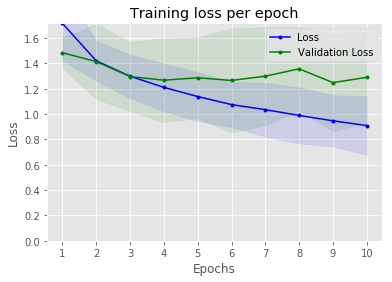

In [13]:
if args.cuda:
    cnn = cnn.cuda()

cnn.learn(data_train, optimizer, data_test, max_epochs=args.max_epochs)

In [14]:
def model_accuracy(output, data):
    _, indices = torch.max(output, 1)

    return accuracy(indices, data[1])
metrics = cnn.evaluate_with_metrics(data_test, 
                                    {'loss': cnn.metric_loss, 'accuracy': model_accuracy})
metrics_mean = {'loss': 0, 'accuracy': 0}
for loss, acc in zip(metrics['loss'], metrics['accuracy']):
    metrics_mean['loss'] += loss
    metrics_mean['accuracy'] += acc.data[0]

qtd = len(metrics['loss'])

print('Loss: {}'.format(metrics_mean['loss'] / qtd))
print('Accuracy: {}'.format(metrics_mean['accuracy'] / qtd))

/usr/local/lib/python3.6/dist-packages/cogitare/core/model.py:411: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  return loss.data[0]


Loss: 1.2881078720092773
Accuracy: 0.5735176205635071


/usr/lib/python3/dist-packages/ipykernel_launcher.py:10: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # Remove the CWD from sys.path while we load stuff.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


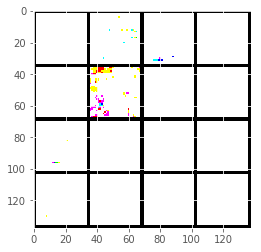

In [15]:
images, labels = next(data_test)
imshow(torchvision.utils.make_grid(images.data[:16], nrow=4))

In [16]:
predicted = cnn.predict((images, None))
predicted.shape

_, predicted_labels = torch.max(predicted, dim=1)
print('Predicted:\n')
showlabels(predicted_labels[:16], 16)

Predicted:

      ship      frog       car     truck

      deer      bird     truck      ship

       car      deer     horse       dog

       car       car      frog      ship



batch:   0%|          | 2/781 [02:20<00:12, 61.09it/s]